## Importing Python Packages

In [2]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import torch
import json
import glob

## Reading Input Files into pandas

In [2]:
dataset = pd.DataFrame(columns=['id','title','abstract','class'])
def read_files(lines,dataset,class_name):
    paper_id, title, abstract = lines[0],lines[1],"".join(lines[2:])
    paper_id = paper_id.strip().split(":")[-1].strip('>')
    title = title.strip().split(":")[-1].strip()
    abstract = abstract.strip().split(":")[-1].strip()
    abstract = abstract.replace("\n","")
    dataset = pd.concat([dataset,
                         pd.DataFrame([{'id':paper_id,'title':title,'abstract':abstract,'class':class_name}])],
                       ignore_index=True)    
    return dataset

all_files = glob.glob('Cancer/*')+glob.glob('Non-Cancer/*')
for files in all_files:
    open_file = open(files,'r')
    lines = open_file.readlines()
    class_name = 'Non-Cancer' if 'Non-Cancer' in files else 'Cancer'
    dataset = read_files(lines,dataset,class_name)

In [3]:
dataset

,id,title,abstract,class
0,31055940,Protocol Description and Preliminary Results.,Patients with familial adenomatous polyposis (...,Cancer
1,36475784,"encorafenib, binimetinib and cetuximab for ear...",The <i>BRAF</i> V600E mutation accounts for ap...,Cancer
2,30917048,Clear Cell Sarcoma of the Kidney.,Clear cell sarcoma of the kidney is an uncommo...,Cancer
3,31163629,Prostaglandin E-Major Urinary Metabolite (PGE-...,PGE-MUM can be a promising biomarker reflectin...,Cancer
4,30985412,Comparison of L-Methyl-11C-Methionine PET With...,L-Methyl-C-methionine PET and MRS bear limited...,Cancer
...,...,...,...,...
995,38441724,Assessment of Autophagy in Leishmania Parasites.,Leishmaniasis is a neglected tropical disease ...,Non-Cancer
996,26059211,Anetoderma in a patient with terminal osseous ...,Terminal osseous dysplasia with pigmentary def...,Non-Cancer
997,29984440,Type-3 von Willebrand disease in India-Clinica...,This study is one of the largest series to def...,Non-Cancer
998,37460897,Mechanistic and evolutionary insights into a t...,RNA-guided type V CRISPR-Cas12 effectors provi...,Non-Cancer


## Running Baseline Model Predictions

In [12]:
model_name='samsaara/medical_condition_classification'
# model_name='parsi-ai-nlpclass/Gp3_medical_doc_classification'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)
model.config.id2label = {0: "Cancer", 1: "Non-Cancer"}
model.config.label2id = {"Cancer": 0, "Non-Cancer": 1}
num_labels = 2
hidden_size = model.classifier.in_features
model.classifier = torch.nn.Linear(hidden_size, num_labels)

In [14]:
for index,row in dataset.iterrows():
    tokens = tokenizer(row['abstract'],return_tensors='pt',padding=True,truncation=True,max_length=512)
    output = model(**tokens)
    prob = torch.sigmoid(output.logits)
    pred = prob.argmax().item()
    dataset.loc[index,'baseline_model_class'] = model.config.id2label[pred]

In [15]:
dataset.to_csv('baseline_model_results.csv',index=False)

In [31]:
dataset=pd.read_csv('./baseline_model_results.csv')

In [39]:
import evaluate
metric = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    # convert the logits to their predicted class
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [50]:
# model_name='parsi-ai-nlpclass/Gp3_medical_doc_classification'
model_name='samsaara/medical_condition_classification'
tokenizer = AutoTokenizer.from_pretrained(model_name,num_labels=2)

## Building Dataset for Fine-Tuning

In [51]:
from datasets import Dataset, ClassLabel

unique_classes = sorted(dataset["class"].unique())
label_feature = ClassLabel(names=unique_classes)
data = Dataset.from_pandas(dataset)
data = data.train_test_split(test_size=0.25)

def encode_labels(example):
    example["labels"] = label_feature.str2int(example["class"])
    return example

data = data.map(encode_labels)

def preprocess_batch(batch):
    tokens = tokenizer(batch["abstract"], truncation=True, padding=True, max_length=512)
    tokens["labels"] = batch["labels"]
    return tokens

tokenized_dataset = data.map(preprocess_batch, batched=True, remove_columns=data["train"].column_names)

Map: 100%|███████████████████████████| 250/250 [00:00<00:00, 1804.90 examples/s]


## Fine-tuning using LoRA

In [52]:
from peft import LoraConfig, get_peft_model

lora_config = LoraConfig(
    task_type="SEQ_CLS",
    inference_mode=False,
    r=8,
    lora_alpha=16,
    lora_dropout=0.1,target_modules=["q_lin","k_lin","v_lin","out_lin"]
)
model = AutoModelForSequenceClassification.from_pretrained(model_name,num_labels=len(unique_classes),
                                                          ignore_mismatched_sizes=True)
model.config.id2label = {0: "Cancer", 1: "Non-Cancer"}
model.config.label2id = {"Cancer": 0, "Non-Cancer": 1}
num_labels = 2
hidden_size = model.classifier.in_features
model.classifier = torch.nn.Linear(hidden_size, num_labels)
lora_model = get_peft_model(model, lora_config)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at samsaara/medical_condition_classification and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([751]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([751, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Initialize Training Parameters

In [ ]:
from transformers import TrainingArguments, Trainer

training_args = TrainingArguments(
    output_dir="./ashish_trained_biobert",
    save_strategy="epoch",
    eval_strategy="epoch",
    learning_rate=0.001,
    weight_decay=0.01,
    load_best_model_at_end=True,
    logging_dir="./logs",
    logging_steps=50,
)

# Initialize Trainer
trainer = Trainer(
    model=lora_model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

## Training LLM and Storing Locally

In [54]:
resume=False
if len(glob.glob('./ashish_trained_biobert/'))>1:
    resume=True
trainer.train(resume_from_checkpoint=resume)
trainer.save_model('./ashish_trained_biobert/')
trainer.tokenizer.save_pretrained('./ashish_trained_biobert/')

Epoch,Training Loss,Validation Loss,Accuracy
1,0.528400,0.280529,0.884000
2,0.237100,0.299675,0.908000
3,0.134200,0.307797,0.912000


/home/ashish/Downloads/Assignment/sklearn-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/home/ashish/Downloads/Assignment/sklearn-env/lib/python3.12/site-packages/torch/utils/data/dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
Trainer.tokenizer is now deprecated. You should use Trainer.processing_class instead.


('./ashish_trained_biobert/tokenizer_config.json',
 './ashish_trained_biobert/special_tokens_map.json',
 './ashish_trained_biobert/vocab.txt',
 './ashish_trained_biobert/added_tokens.json',
 './ashish_trained_biobert/tokenizer.json')

## Classifying Using Fine-Tuned LLM

In [83]:
tuned_tokenizer=AutoTokenizer.from_pretrained('./ashish_trained_biobert/')
tuned_model=AutoModelForSequenceClassification.from_pretrained('./ashish_trained_biobert/',num_labels=2,ignore_mismatched_sizes=True)
tuned_model.config.id2label = {0: "Cancer", 1: "Non-Cancer"}
tuned_model.config.label2id = {"Cancer": 0, "Non-Cancer": 1}

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at samsaara/medical_condition_classification and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([751]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([751, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [84]:
for index,row in dataset.iterrows():
    tokens = tuned_tokenizer(row['abstract'],return_tensors='pt',padding=True,truncation=True,max_length=512)
    output = model(**tokens)
    prob = torch.sigmoid(output.logits)
    pred = prob.argmax().item()
    dataset.loc[index,'finetuned_model_class'] = tuned_model.config.id2label[pred]

In [85]:
dataset.to_csv('finetuned_model_results.csv',index=False)

In [113]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score

## Baseline Model Performance

Accuracy: 50.3%
F1-score: 0.6625933469110659


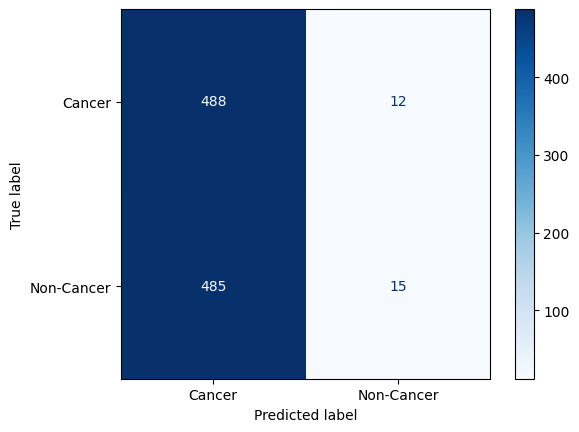

In [118]:
cm=confusion_matrix(dataset['class'],dataset['baseline_model_class'])
f1=f1_score(dataset['class'],dataset['baseline_model_class'],pos_label='Cancer')
print('Accuracy: ',(cm[0,0]+cm[1,1])/cm.sum()*100,'%',sep='')
print('F1-score:',f1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Cancer','Non-Cancer'])
disp.plot(cmap='Blues')

## Fine-Tuned Model Performance

Accuracy: 91.4%
F1-score: 0.9094736842105263


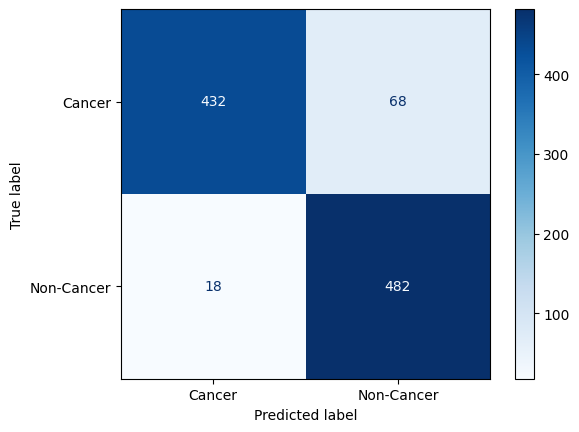

In [120]:
cm=confusion_matrix(dataset['class'],dataset['finetuned_model_class'])
f1=f1_score(dataset['class'],dataset['finetuned_model_class'],pos_label='Cancer')
print('Accuracy: ',(cm[0,0]+cm[1,1])/cm.sum()*100,'%',sep='')
print('F1-score:',f1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=['Cancer','Non-Cancer'])
disp.plot(cmap='Blues')